# Global Path Weighting

This notebook will implement and evaluate a method to weight hetnet paths in such a way that they can be compared between metapaths. This is an improvement on ranking by path degree product (pdp), as pdps are not comparable for paths that are part of different metapaths.

## Proposed Weighting Method

Thanks to the work done on [generating empirical p-values for metapaths](https://github.com/greenelab/hetmech/issues/134), we can compare the relative importance of different metapaths for a given node pair in a hetnet. To allow comparison between individual paths, we can take the negative log of the p-value (for readability), multiply it for the path degree product for the node pair, and adjust the result based on the number of metapaths of that length.

In [1]:
import math

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas

from neo4j import GraphDatabase
import hetnetpy.readwrite
import hetnetpy.neo4j
from src.database_utils import get_db_connection

In [2]:
# Note that SQL needs extra quotation marks to treat the identifiers as strings
compound = "DB01156"  # Bupropion
disease = "DOID:0050742"  # nicotine dependences

In [3]:
# Query db with psycopg2 to get the top ten metapaths for this pair, and their p-values
connection = get_db_connection()

# Get the p-values for the top ten paths for the given compound and disease
query = f"""\
SELECT n1.name, n2.name, metapath_id, pc.p_value 
FROM dj_hetmech_app_pathcount pc 
    JOIN dj_hetmech_app_node n1 ON n1.id = source_id 
    JOIN dj_hetmech_app_node n2 ON n2.id = target_id  
WHERE (n1.identifier={disease!r} AND n2.identifier={compound!r})
    OR (n1.identifier={compound!r} AND n2.identifier={disease!r})
ORDER BY pc.p_value ASC 
LIMIT 10;
"""
print(query)

cursor = connection.cursor()

cursor.execute(query)
tuple_metapaths = cursor.fetchall()

connection.close()

SELECT n1.name, n2.name, metapath_id, pc.p_value 
FROM dj_hetmech_app_pathcount pc 
    JOIN dj_hetmech_app_node n1 ON n1.id = source_id 
    JOIN dj_hetmech_app_node n2 ON n2.id = target_id  
WHERE (n1.identifier='DOID:0050742' AND n2.identifier='DB01156')
    OR (n1.identifier='DB01156' AND n2.identifier='DOID:0050742')
ORDER BY pc.p_value ASC 
LIMIT 10;



In [4]:
# Take the negative log of the p-values

# Convert metapaths to a list of lists instead of a tuple of tuples to allow item assignment
list_metapaths = [list(metapath) for metapath in tuple_metapaths]
for i, _ in enumerate(tuple_metapaths):
    list_metapaths[i][3] = -1 * math.log10(tuple_metapaths[i][3])
    
print([metapath[2] for metapath in list_metapaths])

['CbGiGaD', 'CbGbCtD', 'CbGaD', 'CpDrDrD', 'CbGbCpD', 'CdGuCtD', 'CpDlAlD', 'CcSEcCtD', 'CpDrD', 'CdGdCpD']


Note from 2020-02-03: stopped rerunning here because public database configured in [60f4826a](https://github.com/greenelab/hetmech/commit/60f4826a951d007eeb19227e19669544e57eeb93) does not store all metapath results. Previousely, this notebook used a database on a Greene Lab workstation which is no longer online. The production database was populated in https://github.com/greenelab/connectivity-search-backend/pull/41.

Could we do this with the API instead at <https://search-api.het.io/>?

In [5]:
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
metagraph = hetnetpy.readwrite.read_metagraph(url)

In [6]:
damping_exponent = 0.4
all_metapath_results = []
for metapath in list_metapaths:
    metapath_data = metagraph.metapath_from_abbrev(metapath[2])
    query = hetnetpy.neo4j.construct_pdp_query(metapath_data, path_style='list', property='identifier')
    driver = GraphDatabase.driver("bolt://neo4j.het.io")
    params = {
        'source': compound,
        'target': disease,
        'w': damping_exponent
    }
    with driver.session() as session:
        metapath_result = session.run(query, params)
        metapath_result = metapath_result.data()
        all_metapath_results.append(metapath_result)
len(all_metapath_results)

10

In [7]:
paths = []
for metapath_result, metapath_info in zip(all_metapath_results, list_metapaths):
    metapath_importance = metapath_info[3]
    for path_dict in metapath_result:
        path_dict = path_dict.copy()
        path_dict['path_importance'] = metapath_importance * path_dict['percent_of_DWPC']
        path_dict['metapath_importance'] = metapath_importance
        path_dict['path'] = '–'.join(path_dict['path'])
        path_dict['metapath_abbr'] = metapath_info[2] 
        paths.append(path_dict)
path_df = (
    pandas.DataFrame(paths)
    .set_index('path')
    .sort_values("path_importance", ascending=False)
)
path_df

,PDP,percent_of_DWPC,path_importance,metapath_importance,metapath_abbr
path,,,,,
Bupropion–CHRNA3–CHRNB4–nicotine dependence,0.013690,92.396717,250.792924,2.714306,CbGiGaD
Bupropion–CHRNA3–Varenicline–nicotine dependence,0.028646,100.000000,243.927569,2.439276,CbGbCtD
Bupropion–CHRNA3–nicotine dependence,0.026062,100.000000,214.475654,2.144757,CbGaD
Bupropion–attention deficit hyperactivity disorder–nicotine dependence,0.078028,100.000000,179.370185,1.793702,CpDrD
Bupropion–panic disorder–alcohol dependence–nicotine dependence,0.023619,58.945526,123.604565,2.096929,CpDrDrD
...,...,...,...,...,...
Bupropion–Vomiting–Varenicline–nicotine dependence,0.000038,0.102223,0.203059,1.986430,CcSEcCtD
Bupropion–Rash–Varenicline–nicotine dependence,0.000038,0.101372,0.201368,1.986430,CcSEcCtD
Bupropion–Dermatitis–Varenicline–nicotine dependence,0.000038,0.101278,0.201181,1.986430,CcSEcCtD


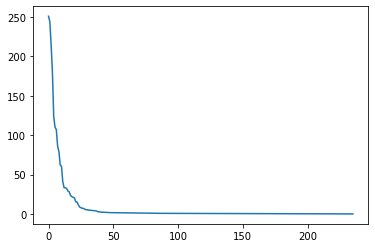

In [8]:
plt.plot(path_df.path_importance.to_list())
plt.show()